## Imports

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Loading data

In [4]:
data_path = '/content/drive/MyDrive/ratings.csv'

data = pd.read_csv(data_path).drop(columns = ['timestamp'])
data = data.rename(columns = {'userId':0,'movieId':1,'rating':2})

data = data.sample(frac = 1).reset_index(drop = True) #Shuffle the dataset
trainlen = int(data.shape[0]*0.8)
testlen = data.shape[0] - trainlen

train = data.iloc[:trainlen]
test = data.iloc[trainlen:].reset_index(drop = True)
n_users = max(data[0])
n_movies = max(data[1])

print(n_users, n_movies)

610 193609


## Creating Data Matrix

In [11]:
train_matrix = np.zeros(((n_users,n_movies)))

for i in range(trainlen):
    curr_usr = train.iloc[i,0]
    curr_mov = train.iloc[i,1]
    curr_rat = train.iloc[i,2]
    train_matrix[curr_usr-1][curr_mov-1] = curr_rat

In [14]:
train_matrix

array([[4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 0. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

## SVD calculation and defining rank-k approximation function

In [17]:
u,s,v_t = np.linalg.svd(train_matrix,full_matrices = False)

def k_rank_approx(k,matrix): 
    if k >= len(s):
        return matrix
    else:
        u_tmp = u[:,:k]
        s_tmp = np.diag(s[:k])
        v_tmp = v_t[:k,:]
        c = np.matmul(u_tmp,np.matmul(s_tmp,v_tmp))
    return c

## Calculating errors in rank-k approximation for different k

In [18]:
errs = []
for k in tqdm(range(1,101)):
    approx = k_rank_approx(k,train_matrix)
    e = 0
    for i in range(testlen):
        rat_curr = test.iloc[i,2]
        usr_curr = test.iloc[i,0]
        mov_curr = test.iloc[i,1]
        e += (rat_curr-approx[usr_curr-1][mov_curr-1])**2
    errs.append(e)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


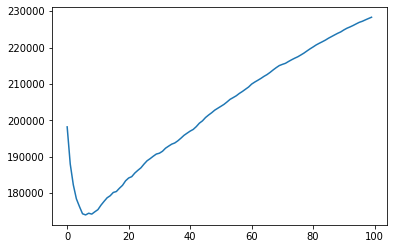

In [19]:
plt.plot(errs)
plt.show()

## Generating data for baseline algorithm

In [26]:
user_ratings = {}
movie_ratings = {}

for i in range(train.shape[0]):
    usr_curr = train.iloc[i,0]
    mov_curr = train.iloc[i,1]
    rat_curr = train.iloc[i,2]
    if usr_curr in user_ratings:
        user_ratings[usr_curr][0] += rat_curr
        user_ratings[usr_curr][1] += 1
    else:
        user_ratings[usr_curr] = [rat_curr,1]

    if mov_curr in movie_ratings:
        movie_ratings[mov_curr][0] += rat_curr
        movie_ratings[mov_curr][1] += 1
    else:
        movie_ratings[mov_curr] = [rat_curr,1]


In [ ]:
user_averages = {}
movie_averages = {}

for i in user_ratings:
    user_averages[i] = user_ratings[i][0]/user_ratings[i][1]

for i in movie_ratings:
    movie_averages[i] = movie_ratings[i][0]/movie_ratings[i][1]

In [ ]:
baseline_train = []
for i in range(train.shape[0]):
    usr_curr = train.iloc[i,0]
    mov_curr = train.iloc[i,1]
    rat_curr = train.iloc[i,2]
    baseline_train.append([user_averages[usr_curr], movie_averages[mov_curr], rat_curr])

x_test=[]
y_test=[]

for i in range(test.shape[0]):
    usr_avg = 0
    mov_avg = 0
    usr_curr = test.iloc[i,0]
    mov_curr = test.iloc[i,1]
    rat_curr = test.iloc[i,2]

    if usr_curr in user_averages:
        usr_avg = user_averages[usr_curr]

    if mov_curr in movie_averages:
        mov_avg = movie_averages[mov_curr]

    x_test.append([usr_avg, mov_avg])
    y_test.append(rat_curr)

baseline_train = np.array(baseline_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

## Training Baseline algorithm, fit using Linear Regression

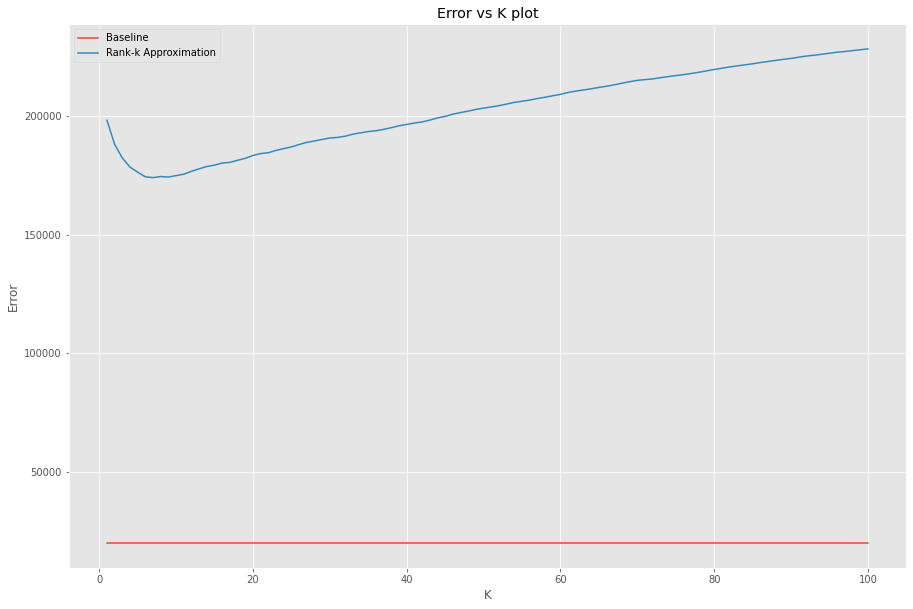

In [34]:
model = LinearRegression(fit_intercept=False)
model.fit(baseline_train[:,:2],baseline_train[:,2])
predicted = model.predict(x_test)
error_baseline = mean_squared_error(predicted,y_test)*len(y_test)

k_values = np.arange(1,101)
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
plt.plot(k_values, [error_baseline for i in range(100)], label='Baseline')
plt.plot(k_values, [errs[i] for i in range(100)], label='Rank-k Approximation')
plt.title('Error vs K plot')
plt.xlabel('K')
plt.ylabel('Error')
plt.legend()
plt.show()